
=== Metrics (test grid) ===
MSE f      : 6.509344530059025e-07
MSE f'     : 4.824778443435207e-06
Max |err| f: 0.0013967528939247131
Max |err| f': 0.005621671676635742


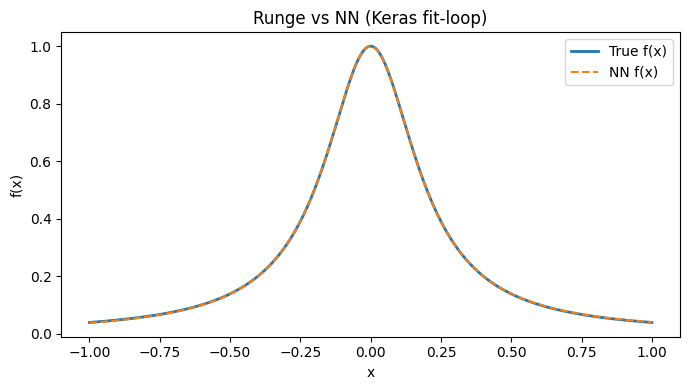

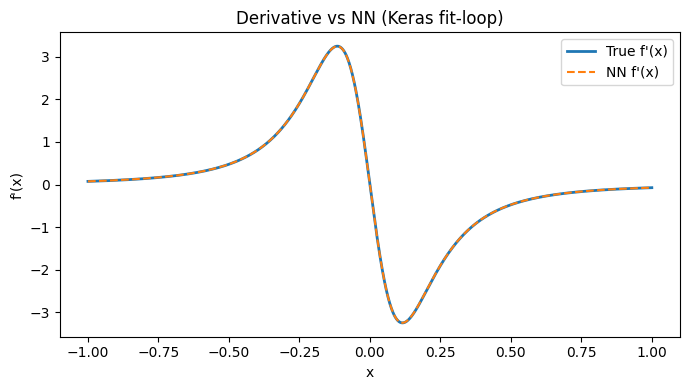

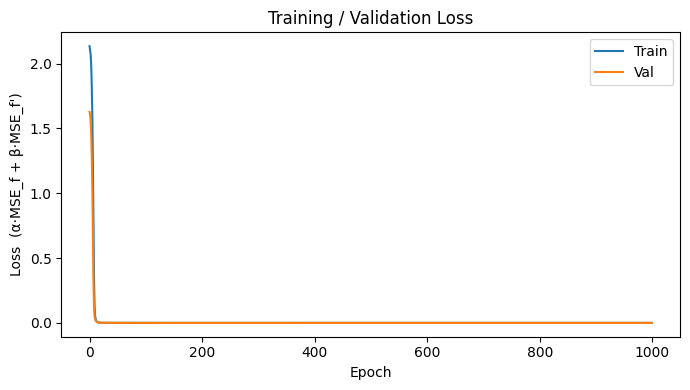

In [2]:
# === HW2 (Programming Assignment, minimal-diff version): Runge + derivative ===
import os, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------- reproducibility ----------
SEED = 12345
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- target function & derivative ----------
def runge_np(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def drunge_np(x):
    return -50.0 * x / (1.0 + 25.0 * x**2) ** 2

# ---------- data ----------
rng = np.random.default_rng(SEED)
N_train, N_val = 2048, 512
X_train = rng.uniform(-1, 1, size=(N_train, 1)).astype(np.float32)
X_val   = rng.uniform(-1, 1, size=(N_val,   1)).astype(np.float32)

y_train  = runge_np(X_train).astype(np.float32)
dy_train = drunge_np(X_train).astype(np.float32)
y_val    = runge_np(X_val).astype(np.float32)
dy_val   = drunge_np(X_val).astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, (y_train, dy_train))).batch(64).prefetch(1)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   (y_val,   dy_val))).batch(128).prefetch(1)

# ---------- minimal-change model (Sequential) ----------
def build_model(width=64, depth=2):
    layers = [tf.keras.layers.Input(shape=(1,))]
    for _ in range(depth):
        layers += [tf.keras.layers.Dense(width, activation="tanh")]
    layers += [tf.keras.layers.Dense(1, activation=None)]
    return tf.keras.Sequential(layers)

# ---------- wrap Sequential into a Model that also learns derivative ----------
class DerivModel(tf.keras.Model):
    def __init__(self, core, alpha=1.0, beta=1.0):
        super().__init__()
        self.core = core
        self.alpha = alpha
        self.beta = beta
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.f_mse = tf.keras.metrics.Mean(name="mse_f")
        self.df_mse = tf.keras.metrics.Mean(name="mse_fprime")

    def call(self, x, training=False):
        return self.core(x, training=training)

    def train_step(self, data):
        x, (y_true, dy_true) = data
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)  # 讓 Tape 追蹤輸入，才能對 x 求導
            y_pred = self.core(x, training=True)
            dy_pred = tape.gradient(y_pred, x)  # dy/dx
            loss_f  = tf.reduce_mean(tf.square(y_pred - y_true))
            loss_df = tf.reduce_mean(tf.square(dy_pred - dy_true))
            loss = self.alpha * loss_f + self.beta * loss_df
        grads = tape.gradient(loss, self.core.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.core.trainable_variables))
        del tape

        self.loss_tracker.update_state(loss)
        self.f_mse.update_state(loss_f)
        self.df_mse.update_state(loss_df)
        return {"loss": self.loss_tracker.result(),
                "mse_f": self.f_mse.result(),
                "mse_fprime": self.df_mse.result()}

    def test_step(self, data):
        x, (y_true, dy_true) = data
        with tf.GradientTape() as tape:
            tape.watch(x)
            y_pred = self.core(x, training=False)
            dy_pred = tape.gradient(y_pred, x)
            loss_f  = tf.reduce_mean(tf.square(y_pred - y_true))
            loss_df = tf.reduce_mean(tf.square(dy_pred - dy_true))
            loss = self.alpha * loss_f + self.beta * loss_df

        self.loss_tracker.update_state(loss)
        self.f_mse.update_state(loss_f)
        self.df_mse.update_state(loss_df)
        return {"loss": self.loss_tracker.result(),
                "mse_f": self.f_mse.result(),
                "mse_fprime": self.df_mse.result()}

    @property
    def metrics(self):
        # 讓 model.reset_metrics() 正確運作
        return [self.loss_tracker, self.f_mse, self.df_mse]

# ---------- build/compile/fit (和你原本流程幾乎一樣) ----------
core = build_model(width=64, depth=2)
model = DerivModel(core, alpha=1.0, beta=1.0)  # 這裡可調權重
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))  # loss 內建於 train_step

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,             # 依時間調整：1000~6000
    verbose=0                # 想看過程就改成 1
)

# ---------- evaluate on dense grid ----------
x_test = np.linspace(-1, 1, 1001, dtype=np.float32).reshape(-1,1)
xT = tf.convert_to_tensor(x_test)
with tf.GradientTape() as tape:
    tape.watch(xT)
    y_hat_T = model(xT, training=False)
    dy_hat_T = tape.gradient(y_hat_T, xT)

y_hat  = y_hat_T.numpy()
dy_hat = dy_hat_T.numpy()
y_true  = runge_np(x_test)
dy_true = drunge_np(x_test)

def mse_np(a,b): return float(np.mean((a-b)**2))
def max_err(a,b): return float(np.max(np.abs(a-b)))

print("\n=== Metrics (test grid) ===")
print("MSE f      :", mse_np(y_hat,  y_true))
print("MSE f'     :", mse_np(dy_hat, dy_true))
print("Max |err| f:", max_err(y_hat,  y_true))
print("Max |err| f':", max_err(dy_hat, dy_true))

# ---------- plots ----------
plt.figure(figsize=(7,4))
plt.plot(x_test, y_true, linewidth = 2, label="True f(x)")
plt.plot(x_test, y_hat, linestyle = "--",  label="NN f(x)")
plt.xlabel("x"); plt.ylabel("f(x)"); plt.title("Runge vs NN (Keras fit-loop)") 
plt.legend() 
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_test, dy_true, linewidth = 2, label="True f'(x)")
plt.plot(x_test, dy_hat, linestyle = "--",  label="NN f'(x)")
plt.xlabel("x"); plt.ylabel("f'(x)")
plt.title("Derivative vs NN (Keras fit-loop)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss  (α·MSE_f + β·MSE_f')")
plt.title("Training / Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


## 使用神經網路同時近似 Runge 函數與其一階導數

### 1) 目的（Purpose）
訓練一個一維神經網路 $f_\theta(x) $ ，**同時**近似：
- 函數值：$ f(x)=\dfrac{1}{1+25x^2} $
- 導數：$ f'(x)=\dfrac{-50x}{(1+25x^2)^2} $

為抑制只擬合函數值時的形狀偏差與邊界震盪，損失函數同時考慮值與導數：
$$
\mathcal L(\theta)
= \alpha \cdot \mathrm{MSE}\big(f_\theta(x),\, f(x)\big)
+ \beta \cdot \mathrm{MSE}\big(\partial_x f_\theta(x),\, f'(x)\big).
$$

---

## 2) 假設函數（Hypothesis Function）
使用以 `tanh` 為非線性的全連接網路（兩層隱藏層），形式為
$$
f_\theta(x)
= W_3\,\tanh\!\Big( W_2\,\tanh(W_1 x + b_1) + b_2 \Big) + b_3,\quad x\in\mathbb{R}.
$$
$\partial_x f_\theta(x)$ 以 TensorFlow `GradientTape` 對輸入 $x$ 求導得到。

---

## 3) 資料抽樣（Data Sampling）
- **輸入分佈**：$ x \sim \mathcal U[-1,1] $（均勻抽樣）。
- **資料量**：訓練集 $N_{\text{train}}=2048$，驗證集 $N_{\text{val}}=512$。
- **標註**：對每個 $x$ 直接以解析式產生
  $$
  y = f(x)=\frac{1}{1+25x^2},\qquad
  y' = f'(x)=\frac{-50x}{(1+25x^2)^2}.
  $$
- **資料餵入**：`tf.data.Dataset` 以 `(x, (y, y'))` 的 tuple 形式傳入模型。

---

## 4) 模型架構（Model Architecture）
- **型式**：`tf.keras.Sequential`
- **結構**：
  - Input：shape = `(1,)`
  - Dense(width=64, activation=`tanh`)
  - Dense(width=64, activation=`tanh`)
  - Dense(1, activation=None)（線性輸出）
- **導數計算**：在 `train_step`／`test_step` 以 `GradientTape` 對輸入 $x$ 求 $\partial_x f_\theta(x)$ 並納入損失。

---

## 5) 訓練設定與參數（Hyperparameters & Training Setup）
- **損失權重**：$\alpha=1.0$、$\beta=1.0$  
  （導數擬合不足可調大 $\beta$ 至 2–5。）
- **最佳化器**：Adam，學習率 $1\times 10^{-3}$。
- **批次大小**：train = 64；val = 128。
- **訓練回合**：`epochs = 1000`。
- **隨機種子**：全域固定為 12345 以利重現。
- **評估**：在等距測試網格 $x\in[-1,1]$（例如 1001 點）計算  
  $\mathrm{MSE}_f=\mathrm{MSE}(f_\theta,f)$、$\mathrm{MSE}_{f'}=\mathrm{MSE}(\partial_x f_\theta,f')$，並回報最大絕對誤差。

---

## 6) 結果（Results）
> 附圖（來自執行程式碼）：  
> 1. 真實 $f(x)$ 與 NN $f_\theta(x)$ 疊圖。  
> 2. 真實 $f'(x)$ 與 NN $\partial_x f_\theta(x)$ 疊圖。  
> 3. 訓練／驗證損失曲線（$\alpha\cdot\mathrm{MSE}_f + \beta\cdot\mathrm{MSE}_{f'}$）。

請填入實際執行輸出的數值（或保留由程式自動列印）：

| 指標 | 數值 |
|---|---|
| Test MSE $f$ | 6.509344530059025e-07 |
| Test MSE $f'$ | 4.824778443435207e-06 |
| Max $\|f_\theta - f \|$ | 0.0013967528939247131 |
| Max $\| \partial_x f_\theta - f' \|$ | 0.005621671676635742 |

由圖片與MSE的數值可以知道，目前所使用的模型可以成功的擬合$f(x)$跟$f^{\prime}(x)$

---
